In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
from astroNN.nn.layers import MCDropout

### In this notebook, we use a compressed version of JLA compilation
#### First, we load the trained AutoEncoder

In [2]:
np.random.seed(0)

In [3]:
decoder = tf.keras.models.load_model('../models/decoderJLA.h5')
autoencoder = tf.keras.models.load_model('../models/autoencoderJLA.h5')
encoder = tf.keras.models.load_model('../models/encoderJLA.h5')
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)

shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)


z = data.values[:,0][shuffle]
dl = data.values[:,1:][shuffle]

scalerdl = StandardScaler()
scalerdl.fit(dl.reshape(-1, 1))
dll = scalerdl.transform(dl.reshape((-1,1)))

avg_encoded = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/notebooks/avg_encoded.txt')

# FFNN

In [4]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)

scalerdl.fit(dl.reshape(-1, 1))
dll = scalerdl.transform(dl.reshape((-1,1)))
dl_train, dl_test = np.split(dll, indx)



In [5]:
def model2_dropout(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.01)(efirst)
    x = Dense(100, activation='relu')(efirst)
    x = MCDropout(0.01)(x)
    x = Dense(100, activation='relu')(x)
    x = MCDropout(0.01)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.01)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
MCDropout_2 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
MCDropout_3 (MCDropout)      (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030  

In [6]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=1,
                                    epochs=10000,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/10000
24/24 [==============================] - 1s 12ms/step - loss: 1.1150 - val_loss: 0.6691
Epoch 2/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.8020 - val_loss: 0.3477
Epoch 3/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.3577 - val_loss: 0.0479
Epoch 4/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.1632 - val_loss: 0.0687
Epoch 5/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.1162 - val_loss: 0.0861
Epoch 6/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0928 - val_loss: 0.0104
Epoch 7/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0121
Epoch 8/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0333
Epoch 9/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0232
Epoch 10/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0255 - val_l

24/24 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0172
Epoch 82/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0027
Epoch 83/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0070
Epoch 84/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0049
Epoch 85/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0565
Epoch 86/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0148 - val_loss: 0.0266
Epoch 87/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0072
Epoch 88/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0199 - val_loss: 0.0030
Epoch 89/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0326
Epoch 90/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.

Epoch 161/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0159
Epoch 162/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0524
Epoch 163/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0020
Epoch 164/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0021
Epoch 165/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 166/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0169 - val_loss: 0.0056
Epoch 167/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0065
Epoch 168/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 6.7166e-04
Epoch 169/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0029
Epoch 170/10000
24/24 [==============================] - 0s 2ms/step 

24/24 [==============================] - 0s 1ms/step - loss: 0.0145 - val_loss: 0.0075
Epoch 241/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0207
Epoch 242/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0204 - val_loss: 0.0106
Epoch 243/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0129
Epoch 244/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0156
Epoch 245/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0243 - val_loss: 0.0040
Epoch 246/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 8.4123e-04
Epoch 247/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0034
Epoch 248/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0180 - val_loss: 0.0010
Epoch 249/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0075 -

24/24 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0075
Epoch 320/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0106
Epoch 321/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0106 - val_loss: 0.0069
Epoch 322/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 323/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 324/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0056
Epoch 325/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 326/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0085
Epoch 327/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0134
Epoch 328/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0064 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0037
Epoch 399/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0046
Epoch 400/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0139 - val_loss: 0.0188
Epoch 401/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0116
Epoch 402/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0020
Epoch 403/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 404/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0031
Epoch 405/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0078
Epoch 406/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0014
Epoch 407/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0070 - val

24/24 [==============================] - 0s 1ms/step - loss: 0.0103 - val_loss: 0.0033
Epoch 478/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0075
Epoch 479/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0181 - val_loss: 0.0123
Epoch 480/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 481/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0110 - val_loss: 0.0072
Epoch 482/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0071
Epoch 483/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0094 - val_loss: 0.0032
Epoch 484/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0141
Epoch 485/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0150
Epoch 486/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0048 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0322
Epoch 557/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0110
Epoch 558/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0090
Epoch 559/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0136
Epoch 560/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 561/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 7.9041e-04
Epoch 562/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 563/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 7.8120e-04
Epoch 564/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0013
Epoch 565/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.00

24/24 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0027
Epoch 636/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 637/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 638/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 5.4195e-04
Epoch 639/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0027
Epoch 640/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0092 - val_loss: 0.0064
Epoch 641/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 7.6643e-04
Epoch 642/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0047
Epoch 643/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0156
Epoch 644/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.01

24/24 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0114
Epoch 715/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0072 - val_loss: 0.0048
Epoch 716/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 717/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0086
Epoch 718/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0010
Epoch 719/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0716
Epoch 720/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0017
Epoch 721/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0085
Epoch 722/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0057
Epoch 723/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0054
Epoch 794/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0031
Epoch 795/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 796/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 797/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0190
Epoch 798/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0040
Epoch 799/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 800/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0068
Epoch 801/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0269
Epoch 802/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0173 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 873/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 874/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 7.2740e-04
Epoch 875/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 876/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0021
Epoch 877/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0096
Epoch 878/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 879/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0089
Epoch 880/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 9.2274e-04
Epoch 881/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.00

24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 952/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 953/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 954/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0117
Epoch 955/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 956/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0112
Epoch 957/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0063
Epoch 958/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 959/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0146
Epoch 960/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0150 - val

24/24 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 1031/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 1032/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 1033/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0012
Epoch 1034/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 1035/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0172
Epoch 1036/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 1037/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 1038/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 1039/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0

24/24 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 1109/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 1110/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 1111/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 9.8732e-04
Epoch 1112/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0056
Epoch 1113/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 5.6236e-04
Epoch 1114/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0019
Epoch 1115/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 1116/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 1117/10000
24/24 [==============================] - 0s 2ms/step - l

24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 1187/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0063
Epoch 1188/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 6.2469e-04
Epoch 1189/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0104
Epoch 1190/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 1191/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 1192/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 2.0338e-04
Epoch 1193/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 1194/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0022
Epoch 1195/10000
24/24 [==============================] - 0s 1ms/step - l

24/24 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 1265/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0030
Epoch 1266/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 1267/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0057
Epoch 1268/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 1269/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 1270/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 1271/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0058
Epoch 1272/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0130
Epoch 1273/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0

24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 1343/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0047
Epoch 1344/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 1345/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0067
Epoch 1346/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0069
Epoch 1347/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0094
Epoch 1348/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0085
Epoch 1349/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0075
Epoch 1350/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0078
Epoch 1351/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0

24/24 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 1421/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0032
Epoch 1422/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 1423/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 1424/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0060
Epoch 1425/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0011
Epoch 1426/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0117
Epoch 1427/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0010
Epoch 1428/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0053
Epoch 1429/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0

24/24 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0019
Epoch 1499/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0038
Epoch 1500/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0137
Epoch 1501/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 1502/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 1503/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 1504/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 1505/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0257
Epoch 1506/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0017
Epoch 1507/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0

24/24 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 1577/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0146
Epoch 1578/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 1579/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 1580/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 1581/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0039
Epoch 1582/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0032
Epoch 1583/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0095 - val_loss: 0.0032
Epoch 1584/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0072
Epoch 1585/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0

24/24 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0014
Epoch 1655/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0040
Epoch 1656/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.1822e-04 - val_loss: 0.0016
Epoch 1657/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 8.6357e-04
Epoch 1658/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 1659/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 1660/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 1661/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 1662/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 1663/10000
24/24 [==============================] - 0s 1ms/step - l

24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 1733/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 1734/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.5806e-04
Epoch 1735/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 1736/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 1.9006e-04
Epoch 1737/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 1738/10000
24/24 [==============================] - 0s 1ms/step - loss: 9.9042e-04 - val_loss: 0.0013
Epoch 1739/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0075
Epoch 1740/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 1741/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 8.5354e-04
Epoch 1811/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0176 - val_loss: 0.0034
Epoch 1812/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0204 - val_loss: 0.0032
Epoch 1813/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 1814/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 1815/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 1816/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0181
Epoch 1817/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 1818/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 1819/10000
24/24 [==============================] - 0s 1ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 1889/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0099
Epoch 1890/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 1891/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 1892/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 1893/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0020
Epoch 1894/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.0057
Epoch 1895/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 6.5927e-04
Epoch 1896/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0109
Epoch 1897/10000
24/24 [==============================] - 0s 2ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 1967/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 0.0055
Epoch 1968/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0169 - val_loss: 9.3497e-04
Epoch 1969/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 9.9243e-04
Epoch 1970/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 1971/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.0825e-04 - val_loss: 0.0022
Epoch 1972/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 1973/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 1974/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 1975/10000
24/24 [==============================] - 0s 1ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 2045/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0016
Epoch 2046/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 2047/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0099 - val_loss: 0.0013
Epoch 2048/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0015
Epoch 2049/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 8.1580e-04
Epoch 2050/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0215
Epoch 2051/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0058
Epoch 2052/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 7.8030e-04
Epoch 2053/10000
24/24 [==============================] - 0s 2ms/step - l

24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 2123/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 2124/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 2125/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0079 - val_loss: 0.0011
Epoch 2126/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 2127/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 9.7209e-04
Epoch 2128/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 2129/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 2130/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 2131/10000
24/24 [==============================] - 0s 1ms/step - loss:

24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 2201/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0107
Epoch 2202/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0024
Epoch 2203/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 2204/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 2205/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 7.5430e-04
Epoch 2206/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 2207/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 2208/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 2209/10000
24/24 [==============================] - 0s 2ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0159
Epoch 2279/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 6.1037e-04
Epoch 2280/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0094 - val_loss: 0.0019
Epoch 2281/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 2282/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 2283/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0084
Epoch 2284/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0012
Epoch 2285/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 8.6386e-04
Epoch 2286/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 2.5387e-04
Epoch 2287/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 2357/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 7.8354e-04
Epoch 2358/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 2359/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0091
Epoch 2360/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0077
Epoch 2361/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 6.4100e-04
Epoch 2362/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 6.9251e-04
Epoch 2363/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 2364/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 1.9102e-04
Epoch 2365/10000
24/24 [==============================] - 0s 2ms/

24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.0117e-04
Epoch 2435/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 2436/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0059
Epoch 2437/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 2438/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 3.6984e-04
Epoch 2439/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0139 - val_loss: 7.9497e-04
Epoch 2440/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 2441/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0156
Epoch 2442/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0105
Epoch 2443/10000
24/24 [==============================] - 0s 1ms/step

24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0125
Epoch 2513/10000
24/24 [==============================] - 0s 2ms/step - loss: 8.2869e-04 - val_loss: 9.0558e-04
Epoch 2514/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 7.6131e-04
Epoch 2515/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0011
Epoch 2516/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 2517/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 2518/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 2519/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 2520/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 1.2971e-04
Epoch 2521/10000
24/24 [==============================] - 0s 2ms/

24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 2591/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0016
Epoch 2592/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 2593/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 2594/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 2595/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 2596/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 9.6552e-04
Epoch 2597/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 2.5347e-04
Epoch 2598/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 4.5494e-04
Epoch 2599/10000
24/24 [==============================] - 0s 1ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0032
Epoch 2669/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 2670/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 2671/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 2672/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 6.4107e-04
Epoch 2673/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 2674/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0087
Epoch 2675/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0080
Epoch 2676/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0156
Epoch 2677/10000
24/24 [==============================] - 0s 2ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 2747/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 8.8058e-04
Epoch 2748/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 2749/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 2750/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 1.3082e-04
Epoch 2751/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 8.9627e-04
Epoch 2752/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 3.4470e-04
Epoch 2753/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 9.5918e-04
Epoch 2754/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0020
Epoch 2755/10000
24/24 [==============================] - 0s 

24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 2825/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0189
Epoch 2826/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0073
Epoch 2827/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 2828/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 2829/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 2830/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0084
Epoch 2831/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 2832/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 2.1869e-04
Epoch 2833/10000
24/24 [==============================] - 0s 2ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0036
Epoch 2903/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0015
Epoch 2904/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0161
Epoch 2905/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0177
Epoch 2906/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 2907/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 8.5198e-04
Epoch 2908/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0114
Epoch 2909/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 2910/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 2911/10000
24/24 [==============================] - 0s 1ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 7.5971e-04
Epoch 2981/10000
24/24 [==============================] - 0s 2ms/step - loss: 4.5171e-04 - val_loss: 8.9722e-04
Epoch 2982/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 3.5929e-04
Epoch 2983/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 2984/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 2985/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 2986/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 9.7548e-04
Epoch 2987/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 5.7878e-04
Epoch 2988/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 2989/10000
24/24 [==============================] -

24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 3059/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 3060/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0021
Epoch 3061/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 6.0607e-04
Epoch 3062/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0076
Epoch 3063/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0108
Epoch 3064/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 3065/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 9.8406e-04
Epoch 3066/10000
24/24 [==============================] - 0s 2ms/step - loss: 8.2735e-04 - val_loss: 0.0031
Epoch 3067/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 3137/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0012
Epoch 3138/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.1993e-04
Epoch 3139/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 9.4927e-04
Epoch 3140/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0081
Epoch 3141/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 3142/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 7.1151e-04
Epoch 3143/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 6.7981e-04
Epoch 3144/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.2823e-04
Epoch 3145/10000
24/24 [==============================] - 0s 

24/24 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 1.1987e-04
Epoch 3214/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 5.5513e-04
Epoch 3215/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0094
Epoch 3216/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0120
Epoch 3217/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 6.0687e-04
Epoch 3218/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 3.4152e-04
Epoch 3219/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 3220/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 3221/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 3222/10000
24/24 [==============================] - 0s 2ms/

24/24 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0095
Epoch 3292/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 3293/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3294/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 3295/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 4.4435e-04
Epoch 3296/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 4.7181e-04
Epoch 3297/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 5.5441e-04
Epoch 3298/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 3299/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 3300/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0126
Epoch 3370/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0043
Epoch 3371/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 3372/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 2.4391e-04
Epoch 3373/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0102 - val_loss: 0.0047
Epoch 3374/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0087
Epoch 3375/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 3.9031e-04
Epoch 3376/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 3377/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 3378/10000
24/24 [==============================] - 0s 1ms/step - l

24/24 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0015
Epoch 3448/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 3449/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 3450/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.1709
Epoch 3451/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 3452/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 3453/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 3454/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0075
Epoch 3455/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 3456/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0

24/24 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 3526/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 3527/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 4.7208e-04
Epoch 3528/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 9.2396e-04
Epoch 3529/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 3530/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 3531/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.4815e-04
Epoch 3532/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 8.1502e-04
Epoch 3533/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 7.3002e-04
Epoch 3534/10000
24/24 [==============================] - 0s 

24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 3604/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0051
Epoch 3605/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 3606/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0016
Epoch 3607/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0095 - val_loss: 0.0049
Epoch 3608/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0102 - val_loss: 0.0066
Epoch 3609/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0061
Epoch 3610/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 3611/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 6.1608e-04
Epoch 3612/10000
24/24 [==============================] - 0s 1ms/step - loss:

24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 3682/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3683/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 3684/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 3685/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 3686/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0079
Epoch 3687/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0013
Epoch 3688/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0122 - val_loss: 0.0042
Epoch 3689/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 3690/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0

24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0050
Epoch 3760/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0154
Epoch 3761/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 3762/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 3763/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0066
Epoch 3764/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 3765/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0105
Epoch 3766/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0012
Epoch 3767/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0110 - val_loss: 0.0026
Epoch 3768/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0

24/24 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 3838/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0195 - val_loss: 0.0019
Epoch 3839/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 3840/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 3841/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 6.7505e-04
Epoch 3842/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 3843/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0017
Epoch 3844/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 3845/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0105
Epoch 3846/10000
24/24 [==============================] - 0s 1ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 7.7954e-04
Epoch 3916/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0061
Epoch 3917/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0023
Epoch 3918/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0020
Epoch 3919/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0040
Epoch 3920/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 3921/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 3922/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0022
Epoch 3923/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 3924/10000
24/24 [==============================] - 0s 2ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 3.6275e-04
Epoch 3994/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 6.5280e-04
Epoch 3995/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 3996/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.4963e-04
Epoch 3997/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 3998/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0123
Epoch 3999/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0022
Epoch 4000/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 4001/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0058
Epoch 4002/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 4072/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4073/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 4074/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 4075/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0100
Epoch 4076/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 4077/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4078/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4079/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 4080/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0

24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 6.9946e-04
Epoch 4150/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 4151/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0108
Epoch 4152/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 4153/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 4154/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 4155/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0073
Epoch 4156/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 4157/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0066
Epoch 4158/10000
24/24 [==============================] - 0s 2ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0102
Epoch 4228/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 0.0425
Epoch 4229/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0028
Epoch 4230/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 9.2508e-04
Epoch 4231/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 4232/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 4233/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 7.6463e-04
Epoch 4234/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 9.4058e-04
Epoch 4235/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 7.4874e-04
Epoch 4236/10000
24/24 [==============================] - 0s 2ms/

24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0085
Epoch 4306/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 4307/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 4308/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 4309/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 4310/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.3862e-04 - val_loss: 0.0012
Epoch 4311/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0087 - val_loss: 0.0047
Epoch 4312/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 4313/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 9.9626e-04
Epoch 4314/10000
24/24 [==============================] - 0s 2ms/step - l

24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0081
Epoch 4384/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0148
Epoch 4385/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 4386/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0054
Epoch 4387/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 4388/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0085
Epoch 4389/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 9.2202e-04
Epoch 4390/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 4391/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 4.6308e-04
Epoch 4392/10000
24/24 [==============================] - 0s 2ms/step - l

24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 6.2148e-04
Epoch 4461/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0075
Epoch 4462/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4463/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 8.5257e-04
Epoch 4464/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 4465/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 4466/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 4467/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 4468/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4469/10000
24/24 [==============================] - 0s 1ms/step - l

24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 4.1016e-04
Epoch 4539/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 4540/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 4541/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 7.9233e-04
Epoch 4542/10000
24/24 [==============================] - 0s 2ms/step - loss: 5.1923e-04 - val_loss: 0.0041
Epoch 4543/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 4544/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 4545/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0064
Epoch 4546/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0077
Epoch 4547/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 8.2101e-04
Epoch 4617/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 4618/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 4619/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 6.6587e-04
Epoch 4620/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0011
Epoch 4621/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 4622/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 7.3283e-04
Epoch 4623/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 4624/10000
24/24 [==============================] - 0s 2ms/step - loss: 9.9051e-04 - val_loss: 0.0019
Epoch 4625/10000
24/24 [==============================] - 0s 2ms/

Epoch 4694/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 7.3503e-04
Epoch 4695/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 4696/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 4697/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 4698/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 4699/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4700/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0023
Epoch 4701/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 4702/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 8.0270e-04
Epoch 4703/10000
24/24 [==============================] 

Epoch 4772/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0060
Epoch 4773/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 4774/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.9024e-04 - val_loss: 5.8724e-04
Epoch 4775/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 4776/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 4777/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 4778/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0061
Epoch 4779/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0147
Epoch 4780/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0059
Epoch 4781/10000
24/24 [==============================] 

24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 9.9869e-04
Epoch 4850/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 4851/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 4852/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0125
Epoch 4853/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 8.5464e-04
Epoch 4854/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 4855/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 8.1685e-04
Epoch 4856/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 4857/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0087
Epoch 4858/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 5.8951e-04
Epoch 4928/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 4929/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0106
Epoch 4930/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0011
Epoch 4931/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 4932/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0080
Epoch 4933/10000
24/24 [==============================] - 0s 2ms/step - loss: 9.9157e-04 - val_loss: 0.0084
Epoch 4934/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 4.2284e-04
Epoch 4935/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 4936/10000
24/24 [==============================] - 0s 1ms/step

Epoch 5005/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 5006/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 5007/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0106
Epoch 5008/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 6.8770e-04
Epoch 5009/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 5010/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 5011/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 5012/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 9.4623e-04
Epoch 5013/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 9.1825e-04
Epoch 5014/10000
24/24 [============================

24/24 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0080
Epoch 5083/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5084/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 7.9965e-04
Epoch 5085/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 5086/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 5087/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 5088/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 3.8797e-04
Epoch 5089/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 5090/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 5091/10000
24/24 [==============================] - 0s 1ms/step - l

Epoch 5160/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 5161/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 5162/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0018
Epoch 5163/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 5164/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5165/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 5166/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 5167/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 7.1258e-04
Epoch 5168/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 9.9458e-04
Epoch 5169/10000
24/24 [==============================] 

Epoch 5238/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 9.6248e-04
Epoch 5239/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0088
Epoch 5240/10000
24/24 [==============================] - 0s 2ms/step - loss: 7.1099e-04 - val_loss: 0.0016
Epoch 5241/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 5242/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 5243/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 9.8572e-04
Epoch 5244/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 5245/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0080
Epoch 5246/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 5247/10000
24/24 [============================

24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5316/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 7.7776e-04
Epoch 5317/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 5318/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0054
Epoch 5319/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0102
Epoch 5320/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0059
Epoch 5321/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 5322/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 5323/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 5324/10000
24/24 [==============================] - 0s 2ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0122
Epoch 5394/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0064
Epoch 5395/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 5396/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0171
Epoch 5397/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 5398/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 5399/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 7.8827e-04
Epoch 5400/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0027
Epoch 5401/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 9.5635e-04
Epoch 5402/10000
24/24 [==============================] - 0s 2ms/step - l

24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 5472/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0024
Epoch 5473/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 8.5250e-04
Epoch 5474/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 5475/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 5476/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 5477/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 5478/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 5479/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0158
Epoch 5480/10000
24/24 [==============================] - 0s 2ms/step - loss:

Epoch 5549/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 3.4749e-04
Epoch 5550/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 8.7869e-04
Epoch 5551/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 5552/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.0805e-04 - val_loss: 0.0012
Epoch 5553/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0013
Epoch 5554/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 5555/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0070 - val_loss: 0.0039
Epoch 5556/10000
24/24 [==============================] - 0s 2ms/step - loss: 7.7253e-04 - val_loss: 9.6420e-04
Epoch 5557/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0050
Epoch 5558/10000
24/24 [====================

24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 5627/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 5.5182e-04
Epoch 5628/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 5629/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 4.0001e-04
Epoch 5630/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5631/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 6.4585e-04
Epoch 5632/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 5633/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 8.5852e-04
Epoch 5634/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0181 - val_loss: 0.0061
Epoch 5635/10000
24/24 [==============================] - 0s 2ms/

24/24 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 3.0398e-04
Epoch 5704/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0063
Epoch 5705/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 2.7953e-04
Epoch 5706/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 5.6608e-04
Epoch 5707/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 5708/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5709/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 5710/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 5711/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0050
Epoch 5712/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 1ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5781/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 5782/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 7.9849e-04
Epoch 5783/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5784/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 5785/10000
24/24 [==============================] - 0s 2ms/step - loss: 6.4499e-04 - val_loss: 0.0048
Epoch 5786/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 6.9048e-04
Epoch 5787/10000
24/24 [==============================] - 0s 2ms/step - loss: 4.5968e-04 - val_loss: 0.0027
Epoch 5788/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 5.5907e-04
Epoch 5789/10000
24/24 [==============================] - 0s 

24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 9.8953e-04
Epoch 5859/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 5860/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 5861/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0109
Epoch 5862/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 5863/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 5864/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 5865/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0111
Epoch 5866/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0085
Epoch 5867/10000
24/24 [==============================] - 0s 2ms/step - loss:

24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 5937/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 7.3300e-04
Epoch 5938/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5939/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 6.7470e-04
Epoch 5940/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 5941/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 5942/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 5943/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0013
Epoch 5944/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 8.1516e-04
Epoch 5945/10000
24/24 [==============================] - 0s 1ms/step

Epoch 6014/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0087
Epoch 6015/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0068
Epoch 6016/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 6.4866e-04
Epoch 6017/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6018/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 6019/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0082
Epoch 6020/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 6021/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 6022/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.2523e-04 - val_loss: 0.0066
Epoch 6023/10000
24/24 [==============================] 

24/24 [==============================] - 0s 2ms/step - loss: 8.8736e-04 - val_loss: 0.0063
Epoch 6092/10000
24/24 [==============================] - 0s 1ms/step - loss: 7.7734e-04 - val_loss: 0.0017
Epoch 6093/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 6094/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0010
Epoch 6095/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 6.5868e-04
Epoch 6096/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6097/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0022
Epoch 6098/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0093
Epoch 6099/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0062
Epoch 6100/10000
24/24 [==============================] - 0s 2ms/step

Epoch 6169/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 6170/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 6171/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 6172/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 6173/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 8.4863e-04
Epoch 6174/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 9.1902e-04
Epoch 6175/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 0.0175
Epoch 6176/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0056
Epoch 6177/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.5100e-04 - val_loss: 3.6348e-04
Epoch 6178/10000
24/24 [========================

24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 6247/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 8.2411e-04
Epoch 6248/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 3.9836e-04
Epoch 6249/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6250/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 3.4868e-04
Epoch 6251/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 9.4874e-04
Epoch 6252/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0062
Epoch 6253/10000
24/24 [==============================] - 0s 2ms/step - loss: 9.9309e-04 - val_loss: 0.0265
Epoch 6254/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 7.8042e-04
Epoch 6255/10000
24/24 [==============================] -

24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.1467e-04
Epoch 6324/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 9.9101e-04
Epoch 6325/10000
24/24 [==============================] - 0s 1ms/step - loss: 9.8373e-04 - val_loss: 0.0010
Epoch 6326/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 5.8831e-04
Epoch 6327/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 6328/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0033
Epoch 6329/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6330/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 4.7482e-04
Epoch 6331/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 6332/10000
24/24 [==============================] - 0s 

24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 6401/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0046
Epoch 6402/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 6403/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 6404/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 6405/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6406/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 6407/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 6408/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 6409/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0

24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 6479/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 6480/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 6481/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6482/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0019
Epoch 6483/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 6484/10000
24/24 [==============================] - 0s 1ms/step - loss: 6.2673e-04 - val_loss: 7.0695e-04
Epoch 6485/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 6486/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 9.4848e-04
Epoch 6487/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 6557/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 6558/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 6559/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 7.9376e-04
Epoch 6560/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 7.1512e-04
Epoch 6561/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 6562/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 6563/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 6.6678e-04
Epoch 6564/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 6565/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 7.7539e-04
Epoch 6634/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6635/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 6636/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0070
Epoch 6637/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0161 - val_loss: 0.0012
Epoch 6638/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 6639/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 4.3659e-04
Epoch 6640/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 6641/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 4.4365e-04
Epoch 6642/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0097
Epoch 6711/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 6712/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 6713/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6714/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 6715/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 6716/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 6717/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 6718/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 7.1379e-04
Epoch 6719/10000
24/24 [==============================] - 0s 2ms/step - loss:

24/24 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 6.5823e-04
Epoch 6788/10000
24/24 [==============================] - 0s 2ms/step - loss: 6.7551e-04 - val_loss: 0.0023
Epoch 6789/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 6790/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0062
Epoch 6791/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0119 - val_loss: 5.8146e-04
Epoch 6792/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 6793/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 6794/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 7.3156e-04
Epoch 6795/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 6.6270e-04
Epoch 6796/10000
24/24 [==============================] - 0s 

24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0068
Epoch 6865/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0100 - val_loss: 9.0633e-04
Epoch 6866/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6867/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 6868/10000
24/24 [==============================] - 0s 2ms/step - loss: 6.4584e-04 - val_loss: 0.0014
Epoch 6869/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 6870/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 5.4390e-04
Epoch 6871/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 6872/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 6873/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0018
Epoch 6942/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6943/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6944/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0131
Epoch 6945/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 4.7664e-04
Epoch 6946/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0026
Epoch 6947/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 4.2844e-04
Epoch 6948/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6949/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 6950/10000
24/24 [==============================] - 0s 2ms/step - l

Epoch 7019/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 7.5060e-04
Epoch 7020/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 7021/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0089
Epoch 7022/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0079
Epoch 7023/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 6.9816e-04
Epoch 7024/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 7025/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 7026/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 5.4583e-04
Epoch 7027/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0133
Epoch 7028/10000
24/24 [============================

24/24 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 6.8395e-04
Epoch 7097/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0020
Epoch 7098/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.2818e-04 - val_loss: 5.3621e-04
Epoch 7099/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 7100/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7101/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 7.2705e-04
Epoch 7102/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0175
Epoch 7103/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0065
Epoch 7104/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0101
Epoch 7105/10000
24/24 [==============================] - 0s 2ms/

Epoch 7174/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 7.6787e-04
Epoch 7175/10000
24/24 [==============================] - 0s 2ms/step - loss: 7.4663e-04 - val_loss: 0.0020
Epoch 7176/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 7177/10000
24/24 [==============================] - 0s 2ms/step - loss: 5.6452e-04 - val_loss: 0.0028
Epoch 7178/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 7179/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0095
Epoch 7180/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0113
Epoch 7181/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 7182/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0090
Epoch 7183/10000
24/24 [============================

24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 5.6668e-04
Epoch 7252/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 5.4736e-04
Epoch 7253/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 7254/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 7255/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0054
Epoch 7256/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 7257/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 5.0282e-04
Epoch 7258/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7259/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 7260/10000
24/24 [==============================] - 0s 1ms/step

Epoch 7329/10000
24/24 [==============================] - 0s 2ms/step - loss: 8.8056e-04 - val_loss: 0.0055
Epoch 7330/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 5.2567e-04
Epoch 7331/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 7332/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0117
Epoch 7333/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0060
Epoch 7334/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 7335/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 7336/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 7337/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 7338/10000
24/24 [==============================] 

24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 7407/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 4.6562e-04
Epoch 7408/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0058
Epoch 7409/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0080 - val_loss: 0.0012
Epoch 7410/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 4.4308e-04
Epoch 7411/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 7412/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 7413/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0086
Epoch 7414/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 7415/10000
24/24 [==============================] - 0s 2ms/step - l

Epoch 7484/10000
24/24 [==============================] - 0s 2ms/step - loss: 6.9608e-04 - val_loss: 6.8358e-04
Epoch 7485/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 7486/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 9.5986e-04
Epoch 7487/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 7488/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 7489/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0075
Epoch 7490/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 7491/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7492/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7493/10000
24/24 [============================

Epoch 7562/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 6.9984e-04
Epoch 7563/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 9.5157e-04
Epoch 7564/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7565/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0088
Epoch 7566/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0060
Epoch 7567/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 7568/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0028
Epoch 7569/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 7570/10000
24/24 [==============================] - 0s 1ms/step - loss: 9.1313e-04 - val_loss: 0.0016
Epoch 7571/10000
24/24 [============================

24/24 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 7640/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0084
Epoch 7641/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0017
Epoch 7642/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0077
Epoch 7643/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7644/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 7645/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0072
Epoch 7646/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 7647/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 6.4727e-04
Epoch 7648/10000
24/24 [==============================] - 0s 1ms/step - loss:

Epoch 7717/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0088 - val_loss: 0.0047
Epoch 7718/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 7719/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7720/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7721/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 4.0155e-04
Epoch 7722/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 7723/10000
24/24 [==============================] - 0s 2ms/step - loss: 8.6880e-04 - val_loss: 0.0012
Epoch 7724/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 5.2737e-04
Epoch 7725/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 8.7850e-04
Epoch 7726/10000
24/24 [========================

Epoch 7795/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 7796/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7797/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 7798/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 7799/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 7800/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 7801/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 7802/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 7803/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 4.0692e-04
Epoch 7804/10000
24/24 [==============================] - 0s

24/24 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0088
Epoch 7873/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 7.5718e-04
Epoch 7874/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0071
Epoch 7875/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 7876/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 7877/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 7878/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 4.1434e-04
Epoch 7879/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 7880/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 4.6435e-04
Epoch 7881/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.1220e-04
Epoch 7950/10000
24/24 [==============================] - 0s 2ms/step - loss: 6.5912e-04 - val_loss: 0.0013
Epoch 7951/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 0.0124
Epoch 7952/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 7953/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7954/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 9.3736e-04
Epoch 7955/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 7956/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 7957/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 6.1038e-04
Epoch 7958/10000
24/24 [==============================] - 0s 1ms/

Epoch 8027/10000
24/24 [==============================] - 0s 2ms/step - loss: 3.7662e-04 - val_loss: 0.0042
Epoch 8028/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 8029/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 8.4737e-04
Epoch 8030/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0088
Epoch 8031/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 6.4380e-04
Epoch 8032/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 8033/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 7.1195e-04
Epoch 8034/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 8.2333e-04
Epoch 8035/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.1785e-04 - val_loss: 0.0020
Epoch 8036/10000
24/24 [================

24/24 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 8105/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 8106/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 3.3303e-04
Epoch 8107/10000
24/24 [==============================] - 0s 2ms/step - loss: 9.6577e-04 - val_loss: 6.4729e-04
Epoch 8108/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 6.9500e-04
Epoch 8109/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 7.2473e-04
Epoch 8110/10000
24/24 [==============================] - 0s 2ms/step - loss: 6.4016e-04 - val_loss: 4.2337e-04
Epoch 8111/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.3498e-04
Epoch 8112/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 9.2915e-04
Epoch 8113/10000
24/24 [=====================

24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 8182/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 8183/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 5.9151e-04
Epoch 8184/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 3.8753e-04
Epoch 8185/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 8186/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 8187/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 8188/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0016
Epoch 8189/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 1.5414e-04
Epoch 8190/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 8259/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 8260/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 8261/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8262/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 8263/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0070
Epoch 8264/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 8265/10000
24/24 [==============================] - 0s 2ms/step - loss: 7.8486e-04 - val_loss: 0.0019
Epoch 8266/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 8267/10000
24/24 [==============================] - 0s 2ms/step - loss:

Epoch 8336/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 8337/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 8338/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 8339/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 8340/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 5.7460e-04
Epoch 8341/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 8342/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0092
Epoch 8343/10000
24/24 [==============================] - 0s 2ms/step - loss: 8.3607e-04 - val_loss: 0.0020
Epoch 8344/10000
24/24 [==============================] - 0s 2ms/step - loss: 7.5712e-04 - val_loss: 5.5623e-04
Epoch 8345/10000
24/24 [========================

24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8414/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 8415/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0049
Epoch 8416/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8417/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 8418/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0121 - val_loss: 9.2542e-04
Epoch 8419/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 7.8952e-04
Epoch 8420/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 6.6514e-04
Epoch 8421/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 8422/10000
24/24 [==============================] - 0s 1ms/step

Epoch 8491/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0029
Epoch 8492/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 8.8408e-04
Epoch 8493/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0088
Epoch 8494/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0094
Epoch 8495/10000
24/24 [==============================] - 0s 2ms/step - loss: 9.4043e-04 - val_loss: 4.6700e-04
Epoch 8496/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 8497/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.3143e-04 - val_loss: 7.0639e-04
Epoch 8498/10000
24/24 [==============================] - 0s 2ms/step - loss: 7.8624e-04 - val_loss: 0.0036
Epoch 8499/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 8500/10000
24/24 [================

24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 8569/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 8.6806e-04
Epoch 8570/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 7.2058e-04
Epoch 8571/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 8572/10000
24/24 [==============================] - 0s 2ms/step - loss: 8.6862e-04 - val_loss: 0.0115
Epoch 8573/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 8574/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 5.8710e-04
Epoch 8575/10000
24/24 [==============================] - 0s 1ms/step - loss: 9.1720e-04 - val_loss: 0.0110
Epoch 8576/10000
24/24 [==============================] - 0s 2ms/step - loss: 4.5236e-04 - val_loss: 6.6049e-04
Epoch 8577/10000
24/24 [=============================

24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 8646/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0116 - val_loss: 0.0047
Epoch 8647/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 9.5415e-04
Epoch 8648/10000
24/24 [==============================] - 0s 1ms/step - loss: 5.3841e-04 - val_loss: 5.7476e-04
Epoch 8649/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 8650/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 8651/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0028 - val_loss: 6.6070e-04
Epoch 8652/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 8.3169e-04
Epoch 8653/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 8654/10000
24/24 [==============================] - 0s 

24/24 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0016
Epoch 8723/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 8724/10000
24/24 [==============================] - 0s 2ms/step - loss: 9.2831e-04 - val_loss: 0.0013
Epoch 8725/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 8726/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 8727/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0044
Epoch 8728/10000
24/24 [==============================] - 0s 2ms/step - loss: 8.2713e-04 - val_loss: 8.4201e-04
Epoch 8729/10000
24/24 [==============================] - 0s 2ms/step - loss: 7.1064e-04 - val_loss: 4.0950e-04
Epoch 8730/10000
24/24 [==============================] - 0s 2ms/step - loss: 9.3858e-04 - val_loss: 0.0013
Epoch 8731/10000
24/24 [==============================] -

Epoch 8800/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8801/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 8802/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0233
Epoch 8803/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0083
Epoch 8804/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 8805/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 8806/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0203 - val_loss: 2.4877e-04
Epoch 8807/10000
24/24 [==============================] - 0s 1ms/step - loss: 8.7994e-04 - val_loss: 5.2331e-04
Epoch 8808/10000
24/24 [==============================] - 0s 2ms/step - loss: 7.2828e-04 - val_loss: 5.6605e-04
Epoch 8809/10000
24/24 [====================

Epoch 8878/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 8879/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 8880/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 4.7734e-04
Epoch 8881/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 8882/10000
24/24 [==============================] - 0s 2ms/step - loss: 8.2991e-04 - val_loss: 0.0066
Epoch 8883/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0087
Epoch 8884/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0117
Epoch 8885/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 8886/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 4.3090e-04
Epoch 8887/10000
24/24 [============================

Epoch 8956/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0191
Epoch 8957/10000
24/24 [==============================] - 0s 2ms/step - loss: 6.2752e-04 - val_loss: 0.0011
Epoch 8958/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8959/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0010 - val_loss: 8.0525e-04
Epoch 8960/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 8961/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 8962/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0167
Epoch 8963/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0044 - val_loss: 0.0213
Epoch 8964/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 8965/10000
24/24 [==============================] 

24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 6.1675e-04
Epoch 9034/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 7.8803e-04
Epoch 9035/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 9036/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 5.9180e-04
Epoch 9037/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 9038/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 9.7415e-04
Epoch 9039/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 5.0042e-04
Epoch 9040/10000
24/24 [==============================] - 0s 2ms/step - loss: 9.9444e-04 - val_loss: 6.2214e-04
Epoch 9041/10000
24/24 [==============================] - 0s 1ms/step - loss: 5.6837e-04 - val_loss: 0.0021
Epoch 9042/10000
24/24 [=========================

24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 9111/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 9112/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 9113/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 9114/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0041
Epoch 9115/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 6.1939e-04
Epoch 9116/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 6.0841e-04
Epoch 9117/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 9118/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 9119/10000
24/24 [==============================] - 0s 2ms/step - l

Epoch 9188/10000
24/24 [==============================] - 0s 2ms/step - loss: 6.4412e-04 - val_loss: 8.0770e-04
Epoch 9189/10000
24/24 [==============================] - 0s 1ms/step - loss: 7.8626e-04 - val_loss: 8.3485e-04
Epoch 9190/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0101
Epoch 9191/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 9192/10000
24/24 [==============================] - 0s 1ms/step - loss: 9.2201e-04 - val_loss: 8.6901e-04
Epoch 9193/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 9194/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 4.5730e-04
Epoch 9195/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 9196/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0139 - val_loss: 0.0026
Epoch 9197/10000
24/24 [============

24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 8.7069e-04
Epoch 9266/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 9267/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0086
Epoch 9268/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0085
Epoch 9269/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 9270/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 9.5918e-04
Epoch 9271/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0049
Epoch 9272/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 8.6852e-04
Epoch 9273/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 9274/10000
24/24 [==============================] - 0s 2ms/step

24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 9343/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9344/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 8.3926e-04
Epoch 9345/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 9346/10000
24/24 [==============================] - 0s 2ms/step - loss: 4.6754e-04 - val_loss: 7.7456e-04
Epoch 9347/10000
24/24 [==============================] - 0s 2ms/step - loss: 2.6549e-04 - val_loss: 0.0010
Epoch 9348/10000
24/24 [==============================] - 0s 1ms/step - loss: 9.4305e-04 - val_loss: 0.0013
Epoch 9349/10000
24/24 [==============================] - 0s 2ms/step - loss: 4.1528e-04 - val_loss: 8.6200e-04
Epoch 9350/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0092
Epoch 9351/10000
24/24 [=============================

24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 9420/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 9421/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 5.7096e-04
Epoch 9422/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0057
Epoch 9423/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9424/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0014
Epoch 9425/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 7.2041e-04
Epoch 9426/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 5.8099e-04
Epoch 9427/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 4.9890e-04
Epoch 9428/10000
24/24 [==============================] - 0s 2ms/

Epoch 9497/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 9498/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0034
Epoch 9499/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 9500/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 9501/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 9502/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0258
Epoch 9503/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 9.5664e-04
Epoch 9504/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 7.8668e-04
Epoch 9505/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0092 - val_loss: 0.0023
Epoch 9506/10000
24/24 [==============================] 

Epoch 9575/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 9576/10000
24/24 [==============================] - 0s 1ms/step - loss: 5.2515e-04 - val_loss: 5.7584e-04
Epoch 9577/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 8.5437e-04
Epoch 9578/10000
24/24 [==============================] - 0s 2ms/step - loss: 6.5556e-04 - val_loss: 6.1426e-04
Epoch 9579/10000
24/24 [==============================] - 0s 2ms/step - loss: 7.0791e-04 - val_loss: 0.0016
Epoch 9580/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9581/10000
24/24 [==============================] - 0s 2ms/step - loss: 7.9834e-04 - val_loss: 6.5610e-04
Epoch 9582/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9583/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0030
Epoch 9584/10000
24/24 [========

24/24 [==============================] - 0s 2ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9653/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 9654/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0095
Epoch 9655/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 9656/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 9.9520e-04
Epoch 9657/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 9658/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0049
Epoch 9659/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 8.1728e-04
Epoch 9660/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 9661/10000
24/24 [==============================] - 0s 1ms/step - l

24/24 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0090
Epoch 9731/10000
24/24 [==============================] - 0s 2ms/step - loss: 8.4594e-04 - val_loss: 0.0045
Epoch 9732/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 8.7569e-04
Epoch 9733/10000
24/24 [==============================] - 0s 1ms/step - loss: 3.4437e-04 - val_loss: 0.0021
Epoch 9734/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 7.7389e-04
Epoch 9735/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 7.0583e-04
Epoch 9736/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0093 - val_loss: 0.0041
Epoch 9737/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0054
Epoch 9738/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 9739/10000
24/24 [==============================] - 0s 

24/24 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 9809/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 5.8933e-04
Epoch 9810/10000
24/24 [==============================] - 0s 2ms/step - loss: 9.2275e-04 - val_loss: 0.0014
Epoch 9811/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 7.8165e-04
Epoch 9812/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0074 - val_loss: 0.0013
Epoch 9813/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0027
Epoch 9814/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0014
Epoch 9815/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 2.5265e-04
Epoch 9816/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 8.6825e-04
Epoch 9817/10000
24/24 [==============================] - 0s 

Epoch 9886/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 9887/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 9888/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 7.0467e-04
Epoch 9889/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 9890/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0011
Epoch 9891/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 9892/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0082
Epoch 9893/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 9894/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0085
Epoch 9895/10000
24/24 [==============================] - 0s

Epoch 9964/10000
24/24 [==============================] - 0s 1ms/step - loss: 0.0021 - val_loss: 0.0061
Epoch 9965/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 7.2197e-04
Epoch 9966/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 9967/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 9968/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0019
Epoch 9969/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0082
Epoch 9970/10000
24/24 [==============================] - 0s 2ms/step - loss: 6.5159e-04 - val_loss: 0.0092
Epoch 9971/10000
24/24 [==============================] - 0s 1ms/step - loss: 7.2626e-04 - val_loss: 5.0384e-04
Epoch 9972/10000
24/24 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 9973/10000
24/24 [========================

Text(0.5, 1.0, 'FFNN+MC-DO')

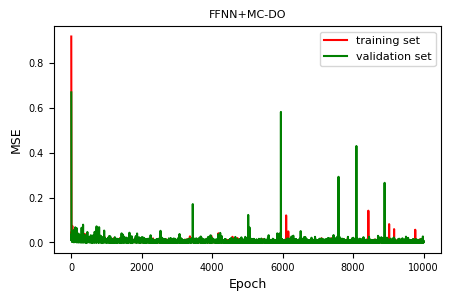

In [7]:
plt.figure(figsize=(5, 3), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=9)
plt.xlabel('Epoch', fontsize=9)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=8)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('FFNN+MC-DO', fontsize=8)

# plt.savefig('loss_dropoutJLA.png', dpi=100)

In [8]:
file3 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/notebooks/fake_binned_JLA.dat'
data3 = pd.read_csv(file3, names=['z', '$D_L$'], sep = " ", skiprows=3)

x_test = data.values[:,0]
# dl = data.values[:,1:][shuffle]
np.shape(x_test)

(31,)

In [9]:
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
# x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 100# Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(x_test)
    

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0, dtype=np.float64)
std_mc_dropout = np.std(predictions, axis=0, dtype=np.float64)



In [10]:
Om = 0.27
# variance network
w0 = -1

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa):
#         if model == 'lcdm':
#             return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
#         elif model == 'owacdm':
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, w0=-1, wa=0.0):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, w0, wa)*(1+z))+43



In [11]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
    fowacdm1.append(distance_modulus(zzz, w0=-10, wa=-100))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

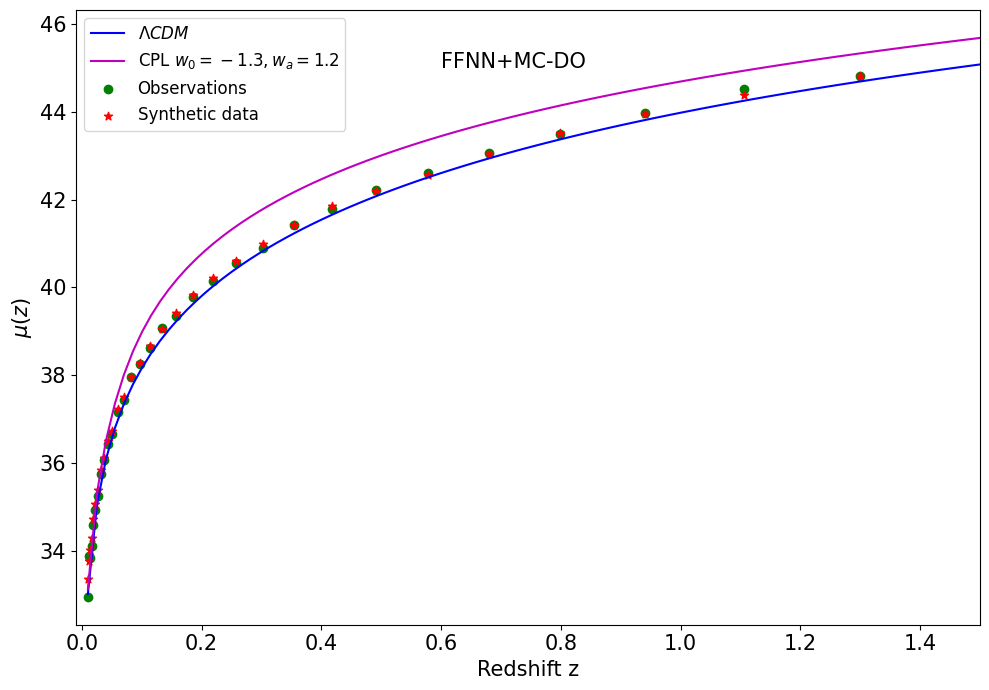

In [12]:
# Plotting
dlfake = scalerdl.inverse_transform(prediction_mc_dropout.reshape(-1,1))
plt.figure(figsize=(10, 7), dpi=100)

# fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
# sigma = np.sqrt(std_mc_dropout.reshape(31,))

plt.scatter(z, dl, c='g', label='Observations')
# plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.scatter(x_test, dlfake, marker='*', c='r', label='Synthetic data')

# plt.errorbar(x_test, dlfake, yerr=sigma
#              , markersize=10, fmt='.', 
#              ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='r',
#              label='Synthetic data')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.plot(zmodel, fowacdm1, label='CPL $w_0 = -1.3, w_a=1.2$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(-0.01, np.max(z)+0.2)
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
# plt.xlim(0, np.max(z))
plt.xticks(fontsize=15)
plt.text(0.6, 45, 'FFNN+MC-DO', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()

plt.legend(loc='upper left', fontsize=12)
# plt.show()
# plt.savefig('DL_dropoutb.png')

In [13]:
index = np.argsort(x_test)
fake_data2 = np.stack((x_test[index], dlfake.reshape(31,)[index]), axis=1)


np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')


In [14]:
# autoencoder.save('autoencoderJLA_DO.h5')
# decoder.save('decoderJLA_DO.h5')
# neural_model2.save('FFNN_JLA_DO.h5')
# encoder.save('encoderJLA_DO.h5')

In [15]:
# plt.figure(figsize=(5, 3), dpi=100)
# plt.plot(model_train.history['loss'], color='r', )
# plt.plot(model_train.history['val_loss'], color='g')
# plt.ylabel('MSE', fontsize=9)
# plt.xlabel('Epoch', fontsize=9)
# plt.legend(['training set', 'validation set'], loc='upper right', fontsize=8)
# plt.xticks(fontsize=7)
# plt.yticks(fontsize=7)
# plt.title('FFNN', fontsize=8)
# plt.savefig("loss_hz.png", dpi=100)